In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (accuracy_score, f1_score, 
                             confusion_matrix, recall_score, 
                             classification_report, 
                             roc_curve, roc_auc_score)
from imblearn.over_sampling import SMOTE

## Load data

In [2]:
data = pd.read_parquet('../data/working_data.parquet')

In [3]:
data.loan_status.value_counts()

loan_status
0.0    1957056
1.0     303612
Name: count, dtype: int64

# Undersampling 

In [4]:
# Shuffle the Dataset.
random_data = data.sample(frac=1, random_state=42)

# Put all the fraud class in a separate dataset.
default_df = random_data.loc[random_data['loan_status'] == 1]

#Randomly select 297033 observations from the non-fraud (majority class)
non_default_df = random_data.loc[random_data['loan_status'] == 0].sample(n=303612, random_state=42)

us_df = pd.concat([default_df, non_default_df])

In [5]:
us_df.head()

,credit_hist,bankrupt,annual_inc,dti,loan_amnt,int_rate,term_60,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,loan_status,grade
1262703,155,0,66000.0,29.24,17500.0,9.17,1.0,0,0,0,0,0,1,1.0,B
240099,269,0,76000.0,21.40,10000.0,13.33,1.0,0,0,0,0,0,1,1.0,C
1241161,61,0,38400.0,14.28,5200.0,20.20,0.0,0,0,0,0,0,1,1.0,E
1919505,247,0,92000.0,28.31,25000.0,19.72,1.0,0,0,0,0,0,1,1.0,D
392562,360,1,56000.0,17.19,6000.0,8.19,0.0,0,0,0,0,1,0,1.0,A


## Logistic Regression

In [6]:
# Create X and y using undersampled dataframe
X = us_df.drop(['loan_status', 'grade'], axis=1)
y = us_df['loan_status']

X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X, y, test_size=.3, random_state=5)

In [7]:
model_us = LogisticRegression().fit(X_train_us, np.ravel(y_train_us))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
preds = model_us.predict_proba(X_test_us)

# # Create dataframes of predictions and true labels
preds_df = pd.DataFrame(preds[:,1][0:], columns = ['PD'])
true_df = y_test_us

In [8]:
# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

        loan_status        PD
0               0.0  0.562883
1               1.0  0.631598
2               0.0  0.232929
3               1.0  0.235652
4               0.0  0.397166
...             ...       ...
182163          1.0  0.705568
182164          1.0  0.408220
182165          1.0  0.427067
182166          0.0  0.381537
182167          1.0  0.566775

[182168 rows x 2 columns]


In [9]:
# Reassign loan status based on the threshold and print the predictions
preds_df['pred_loan_status'] = preds_df['PD'].apply(lambda x: 1 if x > 0.65 else 0)
print("Non-Default / Default predictions at 65% Threshhold: ")
print(preds_df['pred_loan_status'].value_counts())

Non-Default / Default predictions at 65% Threshhold: 
pred_loan_status
0    157653
1     24515
Name: count, dtype: int64


In [10]:
# Print the confusion matrix
print("Confusion Matrix at 65% Threshhold: ")
print(confusion_matrix(y_test_us, preds_df['pred_loan_status']))

Confusion Matrix at 65% Threshhold: 
[[83731  7537]
 [73922 16978]]


In [11]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test_us, preds_df['pred_loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.53      0.92      0.67     91268
     Default       0.69      0.19      0.29     90900

    accuracy                           0.55    182168
   macro avg       0.61      0.55      0.48    182168
weighted avg       0.61      0.55      0.48    182168



0.6082407448069913


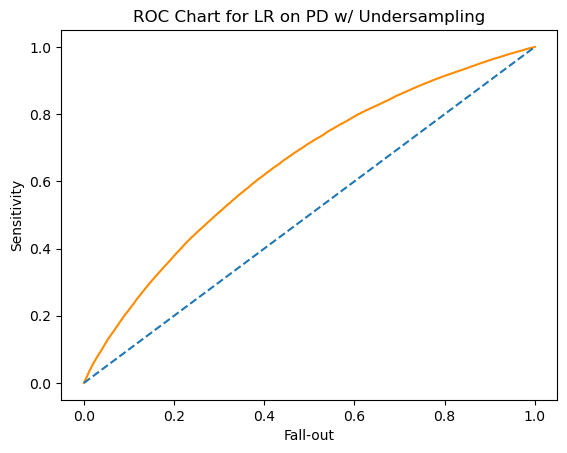

The AUC score is:  0.6485209183143849


In [12]:
# Print the accuracy score of the model
print(model_us.score(X_test_us, y_test_us))

prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test_us, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for LR on PD w/ Undersampling")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()


auc = roc_auc_score(y_test_us, prob_default)
print("The AUC score is: ", auc)

# Oversampling

In [13]:
# Create X and y using processed_df

X = data.drop(['loan_status', 'grade'], axis=1)
y = data['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=5)

In [14]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='auto', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)
oversampled_train.columns = data.drop(['grade'], axis=1).columns

In [15]:
model_os = LogisticRegression().fit(oversampled_trainX, np.ravel(oversampled_trainY))

# Create predictions of probability for loan status using test data
# .predict_proba creates an array of probabilities of default: [[non-defualt, default]]
preds = model_os.predict_proba(X_test)

# # Create dataframes of predictions and true labels
preds_df_os = pd.DataFrame(preds[:,1][0:], columns = ['PD'])
true_df_os = y_test

In [16]:
# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df_os], axis = 1))

        loan_status        PD
0               0.0  0.628499
1               1.0  0.511214
2               0.0  0.333079
3               1.0  0.436930
4               0.0  0.398162
...             ...       ...
678196          NaN  0.492461
678197          NaN  0.554884
678198          NaN  0.535228
678199          NaN  0.409220
678200          NaN  0.449542

[678201 rows x 2 columns]


In [17]:
# Reassign loan status based on the threshold and print the predictions
preds_df_os['pred_loan_status'] = preds_df_os['PD'].apply(lambda x: 1 if x > 0.65 else 0)
print("Non-Default / Default predictions at 65% Threshhold: ")
print(preds_df_os['pred_loan_status'].value_counts())

Non-Default / Default predictions at 65% Threshhold: 
pred_loan_status
0    639419
1     38782
Name: count, dtype: int64


In [18]:
# Print the confusion matrix
print("Confusion Matrix at 65% Threshhold: ")
print(confusion_matrix(y_test, preds_df_os['pred_loan_status']))

Confusion Matrix at 65% Threshhold: 
[[557551  29035]
 [ 81868   9747]]


In [19]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, preds_df_os['pred_loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.87      0.95      0.91    586586
     Default       0.25      0.11      0.15     91615

    accuracy                           0.84    678201
   macro avg       0.56      0.53      0.53    678201
weighted avg       0.79      0.84      0.81    678201



0.5225987575954621


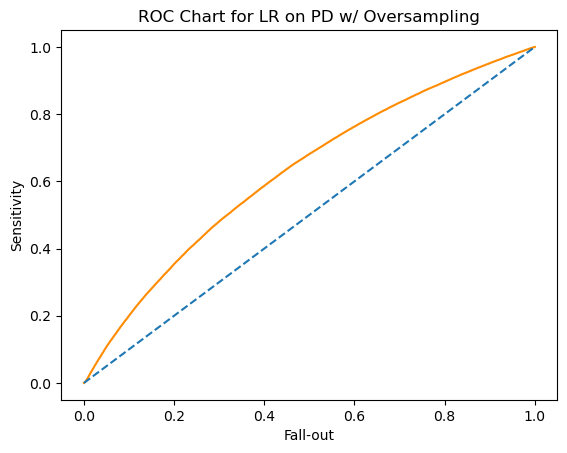

The AUC score is:  0.626153111242349


In [20]:
# Print the accuracy score the model
print(model_os.score(X_test, y_test))

lr_prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, lr_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for LR on PD w/ Oversampling")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()


auc = roc_auc_score(y_test, lr_prob_default)
print("The AUC score is: ", auc)

## Results -> Undersampling vs Oversampling

Model 1 (Undersampling) seems to perform better overall with higher values for accuracy, precision, recall, and F1-score. Model 2 (Oversampling) has higher precision for the "Default" class, which means when it predicts a default, it's more likely to be correct. However, Model 1 has higher recall, indicating it's better at identifying true positives for the "Default" class.

As such, Model 1 is better at identifying defaults and Model 2 is more confident at predicting defaults.

For this reason, we will compare Model 2 to another techniue as our goal is to confidently predict defaults.

### Balanced Bagging Classifier (Oversampling)

In [21]:
# Create an object of the classifier and fit oversampled training data to the object
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0).fit(oversampled_trainX, np.ravel(oversampled_trainY))

# Create predictions of probability for loan status using test data
bbc_preds = bbc.predict_proba(X_test)

In [22]:
# Create dataframes of predictions and true labels
bbc_preds_df = pd.DataFrame(bbc_preds[:,1][0:], columns = ['bbc_pred_PD'])
true_df_bbc = y_test

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), bbc_preds_df], axis = 1))

        loan_status  bbc_pred_PD
0               0.0          0.2
1               1.0          0.0
2               0.0          0.3
3               1.0          0.0
4               0.0          0.0
...             ...          ...
678196          NaN          0.1
678197          NaN          0.1
678198          NaN          0.1
678199          NaN          0.1
678200          NaN          0.2

[678201 rows x 2 columns]


In [23]:
# Reassign loan status based on the threshold and print the predictions
bbc_preds_df['bbc_pred_loan_status'] = bbc_preds_df['bbc_pred_PD'].apply(lambda x: 1 if x > 0.65 else 0)
print("Non-Default / Default predictions at 65% Threshhold: ")
print(bbc_preds_df['bbc_pred_loan_status'].value_counts())

Non-Default / Default predictions at 65% Threshhold: 
bbc_pred_loan_status
0    663321
1     14880
Name: count, dtype: int64


In [24]:
# Print the confusion matrix
print("Confusion Matrix at 65% Threshhold: ")
print(confusion_matrix(y_test, bbc_preds_df['bbc_pred_loan_status']))

Confusion Matrix at 65% Threshhold: 
[[575895  10691]
 [ 87426   4189]]


In [25]:
# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, bbc_preds_df['bbc_pred_loan_status'], target_names=target_names))

              precision    recall  f1-score   support

 Non-Default       0.87      0.98      0.92    586586
     Default       0.28      0.05      0.08     91615

    accuracy                           0.86    678201
   macro avg       0.57      0.51      0.50    678201
weighted avg       0.79      0.86      0.81    678201



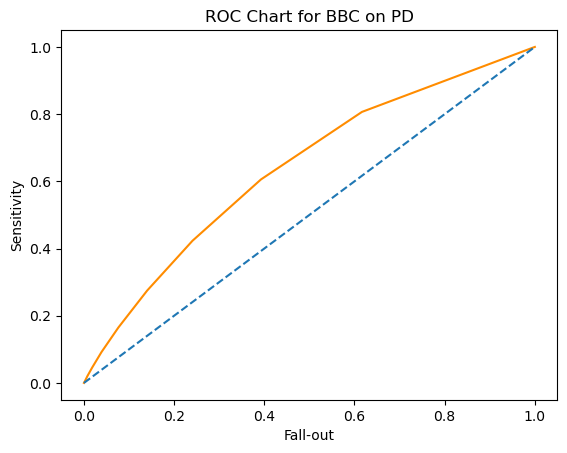

The AUC score is:  0.6383978092350457


In [26]:
bbc_prob_default = bbc_preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, bbc_prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Chart for BBC on PD")
plt.xlabel("Fall-out")
plt.ylabel("Sensitivity")
plt.show()

bbc_auc = roc_auc_score(y_test, bbc_prob_default)
print("The AUC score is: ", bbc_auc)

### Result -> Oversampling Logistic Regression vs Balance Bagging

Logistic regression is better than Balance Bagging Classifier.

As such, we will use the results from the logistic regression for other calculations

## Exploring Logistic Regression Result

In [27]:
preds_df_os

,PD,pred_loan_status
0,0.628499,0
1,0.511214,0
2,0.333079,0
3,0.436930,0
4,0.398162,0
...,...,...
678196,0.492461,0
678197,0.554884,0
678198,0.535228,0
678199,0.409220,0


In [28]:
true_df_os

396949     0.0
278106     0.0
1456307    0.0
806392     0.0
1768493    0.0
          ... 
3248       0.0
2242452    1.0
626771     1.0
2224967    0.0
2081925    0.0
Name: loan_status, Length: 678201, dtype: float64